## Proximity tools

In this tutorial, you'll learn how to use [Xarray-Spatial's proximity toolset](https://xarray-spatial.org/user_guide/proximity.html) to measure distances between points. You'll focus on an area of the Amazon rainforest around Oriximiná, Brazil, using data from the [European Commission Joint Research Centre's Global Surface Water Dataset](https://planetarycomputer-staging.microsoft.com/dataset/jrc-gsw).

Xarray-Spatial offers three proximity tools:
* [Proximity Distance](https://xarray-spatial.org/reference/_autosummary/xrspatial.proximity.proximity.html): for each point in the input raster, this tool calculates the distance to the nearest of a set of target points or source points.
* [Proximity Allocation](https://xarray-spatial.org/reference/_autosummary/xrspatial.proximity.allocation.html): for each cell in the input raster, this tool identifies the nearest source or target point (the 'allocation' point).
* [Proximity Direction](https://xarray-spatial.org/reference/_autosummary/xrspatial.proximity.direction.html): for each cell in the input raster, this tool returns the direction to the nearest source point (the 'allocation').

In [1]:
import pystac_client
import rasterio
import rasterio.mask
import numpy as np
import planetary_computer as pc
import stackstac

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap

from xrspatial import proximity, allocation, direction

### Prepare and load the data

This example uses a small amount of data. Set up a local Dask "cluster" on a single machine to process the data in parallel.

In [2]:
from dask.distributed import Client

client = Client()
print(f"/proxy/{client.scheduler_info()['services']['dashboard']}/status")

/proxy/8787/status


You'll analyze a small area in the Amazon rainforest located around Oriximiná, State of Pará, Brazil. The region of interest contains parts of the Amazon River and smaller rivers such as the Nhamundá River, Trombetas River, and Paru de Oeste River. 

Use `pystac-client` to find all [STAC Items](https://github.com/radiantearth/stac-spec/blob/master/overview.md#item-overview) covering that area:

In [3]:
bounds = [-57.151965, -2.530125, -55.710724, -1.179033]

catalog = pystac_client.Client.open(
    "https://planetarycomputer-staging.microsoft.com/api/stac/v1"
)
jrc = catalog.search(collections=["jrc-gsw"], bbox=bounds)

items = list(jrc.get_items())
print(f"Returned {len(items)} Items")

Returned 1 Items


In [4]:
item = items[0]
item

<Item id=60W_0Nv1_3_2020>

This notebook uses these three assets of the dataset: Maximum Water Extent, Water Seasonality, and Water Transitions. Use [stackstac.stack](https://stackstac.readthedocs.io/en/latest/api/main/stackstac.stack.html) to load the item data, select the desired assets, and crop the area to our bounds of interest. See the [jrc-gsw example notebook](../datasets/jrc-gsw/jrc-gsw-example.ipynb) to learn more about how to use this dataset.

In [5]:
assets_of_interest = ["extent", "seasonality", "transitions"]

data = (
    stackstac.stack(
        [pc.sign(item).to_dict()],
        assets=assets_of_interest,
        bounds=bounds,
        chunksize=3000,
    )
    .isel(time=0)
    .persist()
)

data

<xarray.DataArray 'stackstac-121a1ca87b0511539d756e2cadcfed2e' (band: 3, y: 5405, x: 5766)>
dask.array<getitem, shape=(3, 5405, 5766), dtype=float64, chunksize=(1, 3000, 3000), chunktype=numpy.ndarray>
Coordinates: (12/16)
    time            datetime64[ns] 2020-07-01
    id              <U15 '60W_0Nv1_3_2020'
  * band            (band) <U11 'extent' 'seasonality' 'transitions'
  * x               (x) float64 -57.15 -57.15 -57.15 ... -55.71 -55.71 -55.71
  * y               (y) float64 -1.179 -1.179 -1.179 -1.18 ... -2.53 -2.53 -2.53
    end_datetime    (band) object None '2020-12-31T11:59:59Z' None
    ...              ...
    start_datetime  (band) object None '2020-01-01T00:00:00Z' None
    proj:bbox       object {0.0, -60.0, -50.0, -10.0}
    sci:doi         <U19 '10.1038/nature20584'
    title           (band) <U20 'Maximum Water Extent' ... 'Transitions'
    description     (band) <U74 'Binary indicator of whether water was ever p...
    epsg            int64 4326
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(-57.152, -2.53025, -55.7105, -...
    crs:         epsg:4326
    transform:   | 0.00, 0.00,-57.15|\n| 0.00,-0.00,-1.18|\n| 0.00, 0.00, 1.00|
    resolution:  0.00025

The JRC Global Surface Water COGs include colormaps for each of the assets. Use the [open](https://rasterio.readthedocs.io/en/latest/api/rasterio.html#rasterio.open) function of [rasterio](https://rasterio.readthedocs.io/en/latest/index.html) to read the GeoTIFFs' metadata and select the three colormaps for the assets you are working with. Before you can use those colormaps, you need to convert them into matplotlib [ListedColormap](https://matplotlib.org/stable/api/_as_gen/matplotlib.colors.ListedColormap.html) objects:

In [6]:
cmaps = {}

for asset_key in assets_of_interest:
    asset = item.assets[asset_key]
    with rasterio.open(pc.sign(item.assets[asset_key].href)) as src:
        colormap_def = src.colormap(1)  # get metadata colormap for band 1
        colormap = [
            np.array(colormap_def[i]) / 256 for i in range(256)
        ]  # transform to matplotlib color format
    cmaps[asset_key] = ListedColormap(colormap)

Next, visualize the data using the corresponding colormap for each of the three assets:

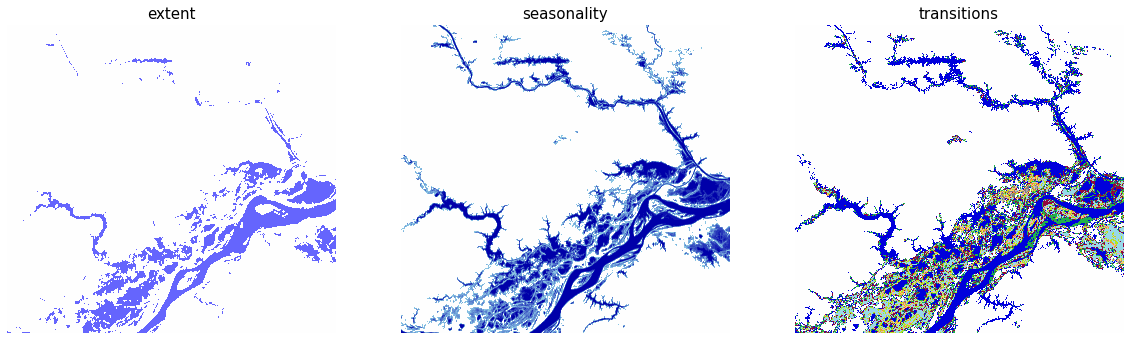

In [7]:
norm = Normalize(0, 255)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 15))

for i, asset_key in enumerate(assets_of_interest):
    ax[i].imshow(
        data.sel(band=asset_key),
        norm=norm,
        cmap=cmaps[asset_key],
    )
    ax[i].set_title(asset_key, fontdict={"fontsize": 15})
    ax[i].set_axis_off()

### Proximity Distance

[xrspatial.proximity.proximity](https://xarray-spatial.org/reference/_autosummary/xrspatial.proximity.proximity.html) takes a `values` raster and, for each point in the raster, computes the distance to the closest *target*. By default, all non-zero values in the raster are used as `target` pixels, but you can provide targest manually instead.

The output raster is the same shape as the input, and the values distance to the closest target point (using the `distance_metric`, euclidean by default).

By default, you'll use Euclidean as the `distance_metric`, the `target_values` parameter is all non-zero pixels in the values raster, and `max_distance` is set to infinity.

In [8]:
extent_data = data.sel(band="extent")

extent_proximity_default = proximity(extent_data).compute()
extent_proximity_default.name = """
    Water Extent proximity distance
    (Euclidean max_distance=infinity)
"""

extent_proximity_default

<xarray.DataArray '\n    Water Extent proximity distance\n    (Euclidean max_distance=infinity)\n' (y: 5405, x: 5766)>
array([[0.1372582 , 0.13700821, 0.13675823, ..., 0.01077033, 0.01086566,
        0.01096586],
       [0.13725569, 0.1370057 , 0.13675571, ..., 0.01053862, 0.01063602,
        0.01073837],
       [0.13725364, 0.13700365, 0.13675366, ..., 0.01030776, 0.01040733,
        0.0105119 ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.15853864, 0.15876181,
        0.15898506],
       [0.        , 0.        , 0.        , ..., 0.15865154, 0.15887456,
        0.15909765],
       [0.        , 0.        , 0.        , ..., 0.15876476, 0.15898762,
        0.15921055]])
Coordinates: (12/16)
    time            datetime64[ns] 2020-07-01
    id              <U15 '60W_0Nv1_3_2020'
    band            <U11 'extent'
  * x               (x) float64 -57.15 -57.15 -57.15 ... -55.71 -55.71 -55.71
  * y               (y) float64 -1.179 -1.179 -1.179 -1.18 ... -2.53 -2.53 -2.53
    end_datetime    object None
    ...              ...
    start_datetime  object None
    proj:bbox       object {0.0, -60.0, -50.0, -10.0}
    sci:doi         <U19 '10.1038/nature20584'
    title           <U20 'Maximum Water Extent'
    description     <U74 'Binary indicator of whether water was ever present ...
    epsg            int64 4326
Attributes:
    spec:        RasterSpec(epsg=4326, bounds=(-57.152, -2.53025, -55.7105, -...
    crs:         epsg:4326
    transform:   | 0.00, 0.00,-57.15|\n| 0.00,-0.00,-1.18|\n| 0.00, 0.00, 1.00|
    resolution:  0.00025

You might wish to set values that are too far from a target value to `NaN`. You can do this by specifying the `max_distance` parameter. We'll set it to the distance between two arbitrary points (using the default [euclidean distance](https://xarray-spatial.org/reference/_autosummary/xrspatial.proximity.euclidean_distance.html)).

In [9]:
from xrspatial import euclidean_distance

p1 = (-57.151965, -2.530125)
p2 = (-57.120526, -2.540378)

d_euclidean = euclidean_distance(p1[0], p2[0], p1[1], p2[1])
d_euclidean

0.03306863665166635

Now we'll specify `max_distance=d_euclidean` to compute the same result, but with all values further than `d_euclidean` from a target set to `NaN`.

In [10]:
extent_proximity = proximity(extent_data, max_distance=d_euclidean).compute()

extent_proximity.name = f"""
    Water Extent proximity distance
    (Euclidean max_distance={d_euclidean:.5f})
"""

Let's visualize the two results.

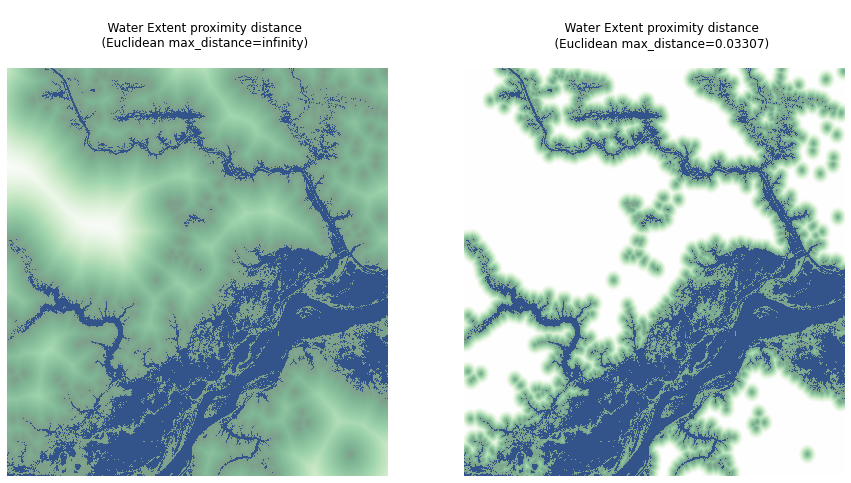

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 7.5))

extent_proximity_default.plot.imshow(cmap="Greens_r", add_colorbar=False, ax=ax1)
extent_data.plot.imshow(
    norm=norm, cmap=cmaps["extent"], add_colorbar=False, alpha=0.5, ax=ax1
)
ax1.set_axis_off()
ax1.set(title=extent_proximity_default.name)

extent_proximity.plot.imshow(cmap="Greens_r", add_colorbar=False, ax=ax2)
extent_data.plot.imshow(
    norm=norm, cmap=cmaps["extent"], add_colorbar=False, alpha=0.5, ax=ax2
)
ax2.set_axis_off()
ax2.set(title=extent_proximity.name);

In this visualization, dark green points are points that are closest to the surface water, while lighter points are further away. Blank points (all white) are further than `max_distance` to the closest point.

### Proximity Allocation

Similar to [xrspatial.proximity.proximity](https://xarray-spatial.org/reference/_autosummary/xrspatial.proximity.proximity.html), [xrspatial.proximity.allocation](https://xarray-spatial.org/reference/_autosummary/xrspatial.proximity.allocation.html) takes an aggregate as its input and finds the smallest distance from each cell to any one of the target points or source points. However, instead of returning the distance, [xrspatial.proximity.allocation](https://xarray-spatial.org/reference/_autosummary/xrspatial.proximity.allocation.html) returns the value of the target point for each pixel.

We'll compute the allocation, using `great_circle_distance` as our distance metric.

In [12]:
from xrspatial import great_circle_distance

d_great_circle = great_circle_distance(p1[0], p2[0], p1[1], p2[1])
d_great_circle

3677.9271626991012

Compute the allocation proximity of the Water Transitions asset data:

In [13]:
transitions_data = data.sel(band="transitions")

transitions_allocation = allocation(
    transitions_data, distance_metric="GREAT_CIRCLE", max_distance=d_great_circle
)
transitions_allocation.name = f"""
    Water Transitions proximity allocation
    (Great Circle max_distance={d_great_circle:.2f})
"""

Visualize the result:

[Text(0.5, 1.0, '\n    Water Transitions proximity allocation\n    (Great Circle max_distance=3677.93)\n')]

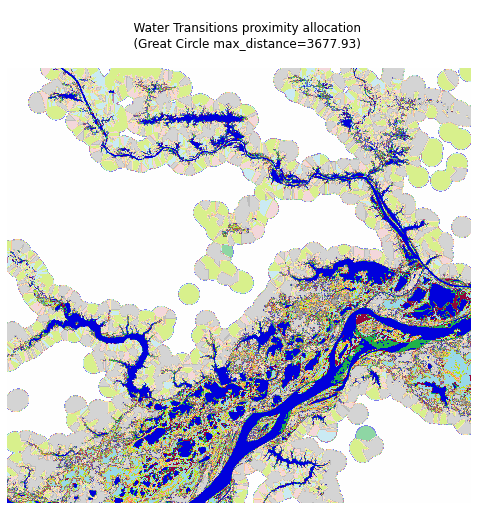

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.set_axis_off()
ax.imshow(transitions_allocation, norm=norm, cmap=cmaps["transitions"])
ax.imshow(transitions_data, norm=norm, cmap=cmaps["transitions"], alpha=0.5)
ax.set(title=transitions_allocation.name)

Notice the blocks in the visualization: each of the differently shaded blocks contains all of the points that share the target point in the center as their nearest target point.

### Proximity Direction

Finally, we'll use [xrspatial.proximity.direction](https://xarray-spatial.org/reference/_autosummary/xrspatial.proximity.direction.html) to compute the *direction* to the nearest target, rather than the distance. The output values range from 0 to 360, with

- 0 is the source cell itself
- 90 is East
- 180 is South
- 270 is West
- 360 is North

In this example, we'll use the `seasonality` band, the `manhattan_distance` metric, and set `target_values=[10, 11, 12]`. The values in `seasonality` indicate the number of months per year that surface water is present in a pixel, so we'll find direction to the nearest pixel with water coverage for at least 10 months of the year.

In [15]:
from xrspatial import manhattan_distance

d_manhattan = manhattan_distance(p1[0], p2[0], p1[1], p2[1])
d_manhattan

0.04169199999999895

Calculate the proximity direction for the Water Seasonality asset data:

In [16]:
seasonality_direction = direction(
    data.sel(band="seasonality"),
    distance_metric="MANHATTAN",
    target_values=[10, 11, 12],
    max_distance=d_manhattan,
).compute()

seasonality_direction.name = f"""
    10-12 months Water Seasonality proximity direction
    (Manhattan max_distance={d_manhattan:.5f})
"""

To better visualization all targets, filter out non-target pixels:

In [17]:
seasonality_data = (
    data.sel(band="seasonality")
    .where(lambda x: x >= 10, other=0)
    .rename("Water Seasonality (10-12 months)")
).compute()

Plot the seasonality data and the direction proximity data next to each other.

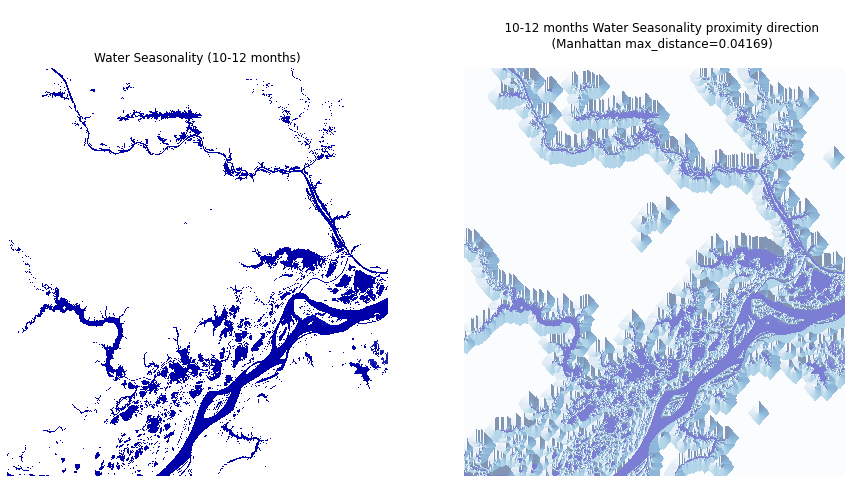

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 7.5))

ax1.set_axis_off()
ax2.set_axis_off()

seasonality_data.plot.imshow(
    norm=norm, cmap=cmaps["seasonality"], ax=ax1, add_colorbar=False
)
ax1.set(title=seasonality_data.name)

seasonality_direction.plot.imshow(cmap="Blues", ax=ax2, add_colorbar=False)
seasonality_data.plot.imshow(
    norm=norm, cmap=cmaps["seasonality"], alpha=0.5, ax=ax2, add_colorbar=False
)
ax2.set(title=seasonality_direction.name);

### Next steps: analyze more datasets

Try using Xarray-Spatial's [Proximity Distance](https://xarray-spatial.org/user_guide/proximity.html#Proximity-Distance), [Proximity Allocation](https://xarray-spatial.org/user_guide/proximity.html#Proximity-Allocation), and [Proximity Direction](https://xarray-spatial.org/user_guide/proximity.html#Proximity-Direction) functions with different areas of interest and different assets of the [European Commission Joint Research Centre's Global Surface Water Dataset](https://planetarycomputer-staging.microsoft.com/dataset/jrc-gsw). Or try using these tools with the [USGS GAP/LANDFIRE National Terrestrial Ecosystems dataset](https://planetarycomputer.microsoft.com/dataset/gap) to analyze proximity distances between different kinds of landcovers.